## Final Project


In [2]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379364 sha256=8ea197a24f64487cb8666a8c4c93cc87aac9c1a214d2e3e942b8478046e15be0
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


### Testing the environment

In [3]:
import gymnasium as gym



env = gym.make("CarRacing-v3", render_mode="human")
obs, _ = env.reset()

for i in range(10000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        break

env.close()


### Building agents and training modules

In [6]:



import gymnasium as gym # type: ignore
import numpy as np # type: ignore
from collections import deque
import random
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import pickle
import time

import matplotlib.pyplot as plt # type: ignore
import cv2 # type: ignore

from collections import deque
import imageio # type: ignore

torch.backends.cudnn.benchmark = True


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")



actions = [ #tried diff things nothing changed, this version supporting steering plus accelration in one action
    np.array([0.0, 0.0, 0.0]),
    np.array([0.0, 1.0, 0.0]),
    np.array([-1.0, 1.0, 0.0]),
    np.array([1.0, 1.0, 0.0]),
    np.array([0.0, 0.0, 0.8]),
] 





## pre-processing

In [7]:
class frame_stacker:

    def __init__(self, stack=4):

        self.stack = stack
        self.frames = deque([], maxlen=stack)

    def reset(self, obs):

        frame = self.pre_process(obs)

        for i in range(self.stack):

            self.frames.append(frame)

        return np.stack(self.frames, axis=0)

    def step(self, obs):

        frame = self.pre_process(obs)
        self.frames.append(frame)
        return np.stack(self.frames, axis=0)

    def pre_process(self, obs):

        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        return  resized/ 255.0
    
class replay_buffer:

    def __init__(self, capacity):

        self.buffer = deque(maxlen=capacity)

    def add(self, s, a, r, s_, d):

        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size):

        return random.sample(self.buffer, batch_size)



## Network building

In [8]:

class cnn(nn.Module):

    def __init__(self, no_of_actions):

        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512), nn.ReLU(),
            nn.Linear(512, no_of_actions)
        )

    def forward(self, x):
        x = x.squeeze(1)
        return self.fc(self.conv(x))






class q_agent:

#changing parameters didnt yield better results, tried buffer_zse = 1000 and 10000 and batch_sizes = 64, 128, 256
    def __init__(self, learning_rate=1e-4, gamma=0.99, epsilon=1.0, epsilon_min = 0.05, epsilon_decay=100000, buffer_size=10000, batch_size=64):


        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0

        self.q_net = cnn(len(actions)).to(device)
        self.target_net = cnn(len(actions)).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(),lr = learning_rate)

        self.buffer = replay_buffer(buffer_size)

    def selected_action(self, state):

        self.steps_done += 1

        self.epsilon = max(self.epsilon_min, self.epsilon - (1.0 - self.epsilon_min) / self.epsilon_decay)


        if np.random.rand() < self.epsilon:
            return random.randrange(len(actions))
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            return self.q_net(state_tensor).argmax().item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

## defining agents, dqn and double dqn

In [9]:

class dqn_agent(q_agent):

    def learn(self):

        if len(self.buffer.buffer) < self.batch_size:
            return

        batch = self.buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().unsqueeze(1).to(device)
        next_states = torch.from_numpy(np.array(next_states)).float().unsqueeze(1).to(device)
        actions = torch.tensor(actions).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards).unsqueeze(1).to(device)
        dones = torch.tensor(dones).float().unsqueeze(1).to(device)

        q_values = self.q_net(states).gather(1, actions)

        q_values_next = self.target_net(next_states).max(1, keepdim=True).values

        targets = rewards + (self.gamma * q_values_next * (1 - dones))

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()




class double_dqn_agent(q_agent):

    def learn(self):

        if len(self.buffer.buffer) < self.batch_size:
            return

        batch = self.buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().unsqueeze(1).to(device)
        next_states = torch.from_numpy(np.array(next_states)).float().unsqueeze(1).to(device)
        actions = torch.tensor(actions).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards).unsqueeze(1).to(device)
        dones = torch.tensor(dones).float().unsqueeze(1).to(device)

        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)

        q_values_next = self.target_net(next_states).gather(1, next_actions)
        targets = rewards + (self.gamma * q_values_next * (1 - dones))

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## training the agent fucntion

In [10]:
def agent_training(agent, env, no_of_episodes=3000, action_repeat=4, target_update_freq=1000, save_path="dqn_agent.pt"):

    # env = gym.make("CarRacing-v3", render_mode=None)
    stacker = frame_stacker(4)
    episode_rewards = []

    for episode in range(no_of_episodes):

        obs, info = env.reset()
        state = stacker.reset(obs)
        episode_reward = 0
        done = False
        steps = 0

        while not done:

            action = agent.selected_action(state)
            cumulative_reward = 0

            for i in range(action_repeat):
                next_obs, reward, terminated, truncated, _ = env.step(actions[action])
                done = terminated or truncated
                cumulative_reward += reward
                if done:
                    break

            best_state = stacker.step(next_obs)
            agent.buffer.add(state, action, cumulative_reward, best_state, done)
            state = best_state
            episode_reward += cumulative_reward
            agent.learn()

            if steps % target_update_freq == 0:
                agent.update_target_network()
            steps += 1

        print(f"episode {episode} | reward: {episode_reward:.2f} | timestamp: {time.strftime('%H:%M:%S')} | epsilon: {agent.epsilon:.3f}")

        episode_rewards.append(episode_reward)

    torch.save(agent.q_net.state_dict(), save_path)
    env.close()
    return episode_rewards

### module to evaulate trained agent

In [11]:
def agent_evaluation(agent_class, model_path):
    
    env = gym.make("CarRacing-v3", render_mode="rgb_array")
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    agent = agent_class()

    agent.q_net.load_state_dict(torch.load(model_path, map_location=device))
    agent.q_net.to(device)
    agent.q_net.eval()

    episode_rewards = []

    for episode in range(10):
        obs, info = env.reset()
        stacker = frame_stacker(4)
        state = stacker.reset(obs)

        total_reward = 0
        done = False

        while not done:

            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                action = agent.q_net(state_tensor).argmax().item()
                
            obs, reward, terminated, truncated, info = env.step(actions[action])
            done = terminated or truncated
            state = stacker.step(obs)
            total_reward += reward

        print(f"episode {episode + 1}: reward = {total_reward:.2f}")
        episode_rewards.append(total_reward)

    print(f'avg reward : {sum(episode_rewards)/10}')

    env.close()
    
    plot_rewards(episode_rewards, label="dqn evaluatiion")




def plot_rewards(rewards, label="dqn"):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode Reward Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()



### training and plotting rewards of episodes by dqn agent on the env

episode 0 | reward: -48.15 | timestamp: 21:57:53 | epsilon: 0.998
episode 1 | reward: -10.89 | timestamp: 21:58:08 | epsilon: 0.995
episode 2 | reward: -38.36 | timestamp: 21:58:23 | epsilon: 0.993
episode 3 | reward: -54.06 | timestamp: 21:58:38 | epsilon: 0.991
episode 4 | reward: -117.29 | timestamp: 21:58:46 | epsilon: 0.989
episode 5 | reward: -72.22 | timestamp: 21:59:00 | epsilon: 0.987
episode 6 | reward: 12.73 | timestamp: 21:59:15 | epsilon: 0.984
episode 7 | reward: -51.72 | timestamp: 21:59:30 | epsilon: 0.982
episode 8 | reward: -8.50 | timestamp: 21:59:46 | epsilon: 0.980
episode 9 | reward: 29.69 | timestamp: 22:00:01 | epsilon: 0.977
episode 10 | reward: -59.18 | timestamp: 22:00:17 | epsilon: 0.975
episode 11 | reward: -16.11 | timestamp: 22:00:32 | epsilon: 0.973
episode 12 | reward: -37.73 | timestamp: 22:00:47 | epsilon: 0.970
episode 13 | reward: -158.61 | timestamp: 22:01:01 | epsilon: 0.968
episode 14 | reward: -33.55 | timestamp: 22:01:16 | epsilon: 0.966
episod

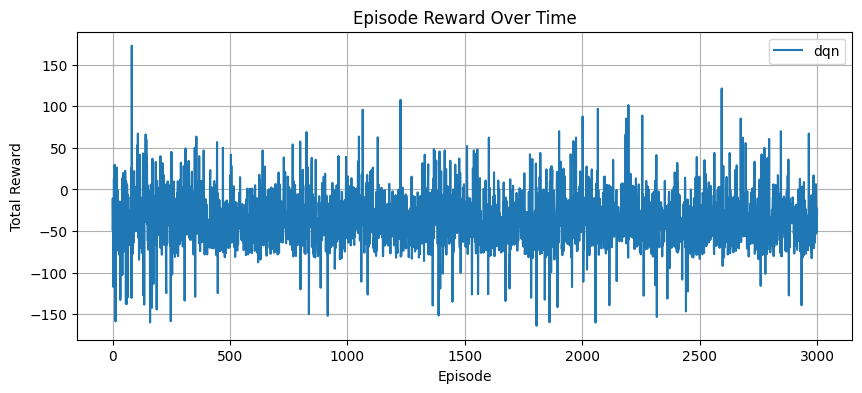

In [6]:

agent = dqn_agent()

env = gym.make("CarRacing-v3", render_mode=None)

rewards = agent_training(agent, env, save_path="dqn_agent.pt")

plot_rewards(rewards,label = "dqn")






/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_46219/3364544582.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_net.load_state_dict(torch.load(model

episode 1: reward = -77.44
episode 2: reward = -73.60
episode 3: reward = -79.52
episode 4: reward = -78.18
episode 5: reward = -60.13
episode 6: reward = -38.36
episode 7: reward = -80.20
episode 8: reward = -57.93
episode 9: reward = -78.49
episode 10: reward = -77.19
avg reward : -70.10417838236636


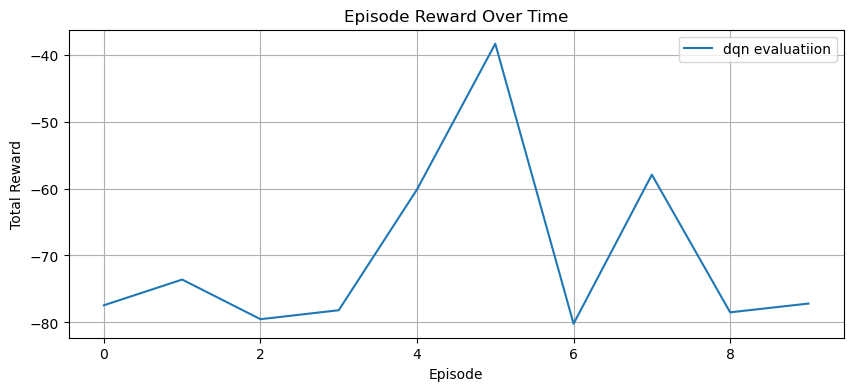

In [8]:

agent_evaluation(dqn_agent, "dqn_agent.pt")


In [9]:



def record_episode(agent_class, model_path, output_video="output_video.mp4"):

    env = gym.make("CarRacing-v3", render_mode="rgb_array")
    stacker = frame_stacker(4)
    frames = []

    agent = agent_class()
    agent.q_net.load_state_dict(torch.load(model_path, map_location=device))
    agent.q_net.to(device)
    agent.q_net.eval()

    obs, info = env.reset()
    state = stacker.reset(obs)

    done = False
    total_reward = 0
    step = 0

    while not done:
        with torch.no_grad():
            
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action = agent.q_net(state_tensor).argmax().item()

        obs, reward, terminated, truncated, info = env.step(actions[action])
        frame = env.render()
        frames.append(frame)

        done = terminated or truncated
        state = stacker.step(obs)
        total_reward += reward
        step += 1

    env.close()


    imageio.mimsave(output_video, frames, fps=30)



In [10]:
record_episode(dqn_agent, model_path="dqn_agent.pt", output_video="dqn_episode.mp4")


/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_46219/2176824271.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_net.load_state_dict(torch.load(model

ref:

A2 code